In [1]:
import numpy as np
import mygrad as mg
import mynn
from database import database
from mynn.layers.dense import dense
from mygrad.nnet.initializers import glorot_normal
from mynn.optimizers.sgd import SGD
import matplotlib.pyplot as plt
from mygrad.nnet.losses import margin_ranking_loss
%matplotlib notebook

In [2]:
import pickle
from pathlib import Path
with Path("/Users/KittyKat/BWSI/BWSI-program/Week-3/resnet18_features.pkl").open('rb') as f:
    resnet18_features = pickle.load(f)

In [71]:
class Encoder:
    def __init__(self, dim_input, dim_output):
        self.dense = dense(dim_input, dim_output, weight_initializer = glorot_normal, bias = False)
        
    def __call__(self, x):
        output = self.dense(x) 
        normalized = output / mg.sqrt(mg.einsum("nd, nd -> n", output, output)).reshape(-1, 1)
        return normalized
    
    @property    
    def parameters(self):
        return self.dense.parameters

In [4]:
db = database("/Users/KittyKat/BWSI/BWSI-program/Week-3/captions_train2014.json") # fix file path in database class?

In [28]:
resnet_keys = list(resnet18_features.keys())
train_images = resnet_keys[0:int(len(resnet18_features.keys()) * 0.8)]
test_images = resnet_keys[-int(len(resnet18_features.keys()) * 0.2) :]

In [29]:
def get_confusor(image_id, img_ids):
    confusor_id = np.random.choice(img_ids)
    while confusor_id == image_id:
        confusor_id = np.random.choice(img_ids)
    return confusor_id

In [12]:
#1
from embedding import create_embeddings
from pathlib import Path
import json

# load COCO metadata
filename = "/Users/KittyKat/BWSI/BWSI-program/Week-3/captions_train2014.json"
with Path(filename).open() as f:
    coco_data = json.load(f)
    
from gensim.models import KeyedVectors
filename = "/Users/KittyKat/BWSI/BWSI-program/Week-3/glove.6B.200d.txt.w2v"
glove = KeyedVectors.load_word2vec_format(filename, binary=False)

/opt/anaconda3/envs/BWSI-week3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [13]:
#2
from embedding import create_embeddings

embeddings = create_embeddings(coco_data, glove)

In [30]:
train_triples = []
count = 0
for image in train_images:
    for caption in db.get_caption_ID(image):
        caption_id = caption
        confusor_id = get_confusor(image, train_images)
        train_triples.append((caption_id, image, confusor_id))
        count += 1
        if count % 5000 == 0:
            print(count)

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
190000
195000
200000
205000
210000
215000
220000
225000
230000
235000
240000
245000
250000
255000
260000
265000
270000
275000
280000
285000
290000
295000
300000
305000
310000
315000
320000
325000
330000


In [33]:
test_triples = []
count = 0
for image in test_images:
    for caption in db.get_caption_ID(image):
        caption_id = caption
        confusor_id = get_confusor(image, test_images)
        test_triples.append((caption_id, image, confusor_id))
        count += 1
        if count % 5000 == 0:
            print(count)

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000


In [32]:
train_triples = np.array(train_triples)
np.save("./train_triples.npy", train_triples)

In [34]:
#run
test_triples = np.array(test_triples)
np.save("./test_triples.npy", test_triples)

In [35]:
#4
def get_descriptors(image_ids):
    descriptors = []
    for image in image_ids:
        descriptors.append(resnet18_features[image])
    return np.array(descriptors)

In [39]:
def get_embeddings(caption_ids):
    embs = []
    for caption in caption_ids:
        embs.append(embeddings[caption])
    return np.array(embs)

In [40]:
get_embeddings(truth_batch[:,0])

array([[ 3.01787892e-02, -5.48476504e-02, -1.02878539e-01, ...,
         4.74698136e-02, -3.48782444e-02,  7.27068253e-02],
       [ 9.67787265e-02,  2.41818715e-02, -3.82903107e-02, ...,
         4.04480184e-02, -3.41823786e-02, -1.30941737e-01],
       [-5.70769011e-02, -9.29811805e-02, -8.45170583e-02, ...,
        -7.97099885e-02, -3.61698321e-02, -4.52276716e-02],
       ...,
       [ 8.25043743e-02,  2.48751443e-02, -9.97008172e-02, ...,
         1.05404288e-01, -4.06872720e-02,  2.82621079e-02],
       [ 5.23617622e-02,  8.99862869e-03, -3.76598978e-02, ...,
        -2.03794531e-02, -1.20695578e-04,  3.86697109e-02],
       [ 5.31639445e-02, -2.68819443e-03, -4.05078081e-02, ...,
         4.97811792e-02, -4.53167790e-02,  3.53107905e-03]])

<IPython.core.display.Javascript object>


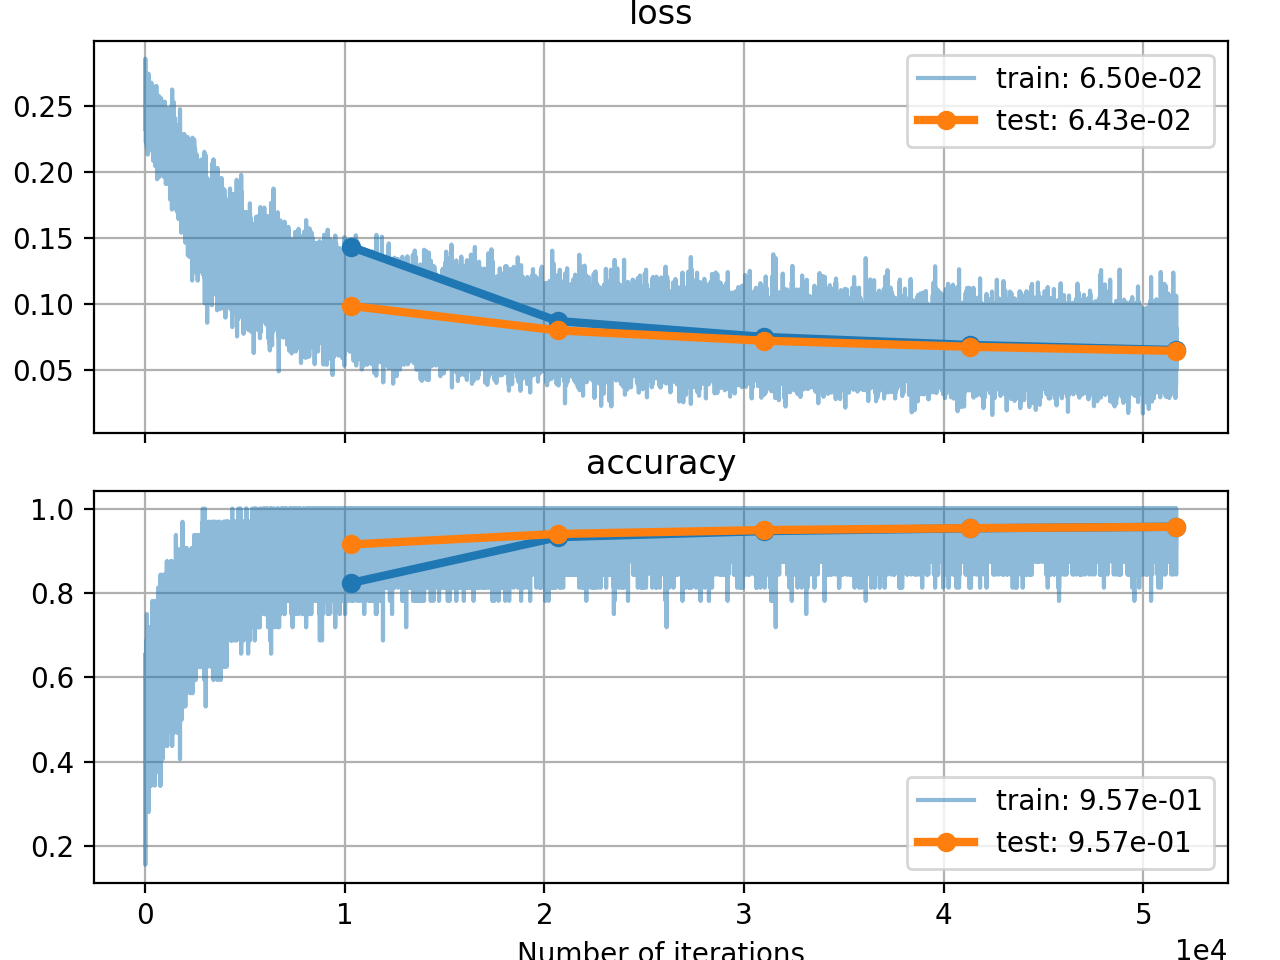

In [75]:
from noggin import create_plot
plotter, fig, ax = create_plot(metrics=["loss", "accuracy"])

In [77]:
#5
model = Encoder(512, 200)

optim = SGD(model.parameters, learning_rate=1e-3, momentum=0.9)

In [78]:
num_epochs = 5
batch_size = 32

for epoch_cnt in range(num_epochs):
    
    # shuffle images
    idxs_train = np.arange(len(train_triples))
    np.random.shuffle(idxs_train)
    idxs_test = np.arange(len(test_triples))
    np.random.shuffle(idxs_test)
    
    for batch_cnt in range(0, len(train_triples)//batch_size):
        # get batch of training data
        batch_indices = idxs_train[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        
        truth_batch = train_triples[batch_indices]
        
        d_true = get_descriptors(truth_batch[:,1]) # find descriptor of true image
        d_confuse = get_descriptors(truth_batch[:,2]) # find descriptor of confusor image
        
        w_true = model(d_true[:,0,:]) # embed true
        w_confuse = model(d_confuse[:,0,:]) # embed confuse

        # compute similarities - do we have to use einsum here?
        # remember to compute caption embeddings
        
        # sim_true = mg.einsum("ni,ni -> n", w_true, embeddings[truth_batch[0]])
        # sim_confuse = mg.einsum("ni,ni -> n", w_confuse, embeddings[truth_batch[0]])
        sim_true = (w_true * get_embeddings(truth_batch[:,0])).sum(axis=1)
        sim_confuse = (w_confuse * get_embeddings(truth_batch[:,0])).sum(axis=1)

        # pass similarities and margin into loss
        loss = margin_ranking_loss(sim_true, sim_confuse, y=1, margin=0.25)
        loss.backward()
        
        acc = np.mean(sim_true > sim_confuse)
        
        plotter.set_train_batch({"loss" : loss.item(), "accuracy":acc}, batch_size=batch_size)
        
        optim.step()
            
    with mg.no_autodiff:
        for i in range(0, len(test_triples)//batch_size):
            batch_indices_t = idxs_test[i * batch_size : (i + 1)*batch_size]
            truth_batch_t = test_triples[batch_indices_t]
            
            d_true_t = get_descriptors(truth_batch_t[:,1]) # find descriptor of true image
            d_confuse_t = get_descriptors(truth_batch_t[:,2]) # find descriptor of confusor image

            w_true_t = model(d_true_t[:,0,:]) # embed true
            w_confuse_t = model(d_confuse_t[:,0,:]) # embed confuse

            # sim_true = mg.einsum("ni,ni -> n", w_true, embeddings[truth_batch[0]])
            # sim_confuse = mg.einsum("ni,ni -> n", w_confuse, embeddings[truth_batch[0]])
            sim_true_t = (w_true_t * get_embeddings(truth_batch_t[:,0])).sum(axis=1)
            sim_confuse_t = (w_confuse_t * get_embeddings(truth_batch_t[:,0])).sum(axis=1)

            # pass similarities and margin into loss
            loss_t = margin_ranking_loss(sim_true_t, sim_confuse_t, 1, 0.25)

            acc_t = np.mean(sim_true_t > sim_confuse_t)
            plotter.set_test_batch(
                dict(loss=loss_t.item(), accuracy=acc_t),
                batch_size=len(test_triples[i : i + batch_size]),
            )
    plotter.set_train_epoch()
    plotter.set_test_epoch()
    print(epoch_cnt)
plotter.plot()

0
1
2
3
4


In [79]:
with open("./weights.pkl", mode="wb") as w:
    pickle.dump(model.parameters.data, w)

In [89]:
resnet18_features[img_id].shape

(1, 512)

In [91]:
img_id=57870
with mg.no_autodiff:
    x = model(resnet18_features[img_id]).data
print(x)

[[ 0.03230347 -0.02327307 -0.01014816 -0.02445346 -0.02893299 -0.02455609
   0.08809074 -0.07387908 -0.00873667 -0.04357745 -0.00161528  0.1010021
   0.03819049 -0.02011448  0.05039837 -0.12026516  0.03316365  0.04588121
   0.0240881   0.00046707 -0.02861786  0.04506522 -0.01349229 -0.12654427
   0.09319062 -0.08659202  0.01298484  0.02080896  0.12905659 -0.01049088
  -0.00568465 -0.08488528  0.02421849  0.04442377 -0.06089672  0.02224076
   0.11849032  0.02082969  0.15826719  0.02793333 -0.02417968  0.05032201
   0.07068715  0.01546193  0.02708555  0.0302579   0.10804158 -0.05491536
   0.00943682  0.13528365 -0.0330632  -0.05345845  0.09358268  0.03770059
   0.05049496  0.05634252  0.09081976  0.05051615 -0.03873279  0.02839697
   0.05753329  0.02410492 -0.01651642  0.0827274  -0.03810741  0.04108401
  -0.19552496  0.07582512 -0.10429812  0.04852692  0.05975723 -0.02919119
   0.03608776  0.02289236  0.04909772 -0.04760073 -0.07726952  0.07221572
  -0.02974067 -0.05019131 -0.05582671 -

In [92]:

with open("./img_weights.pkl", mode="wb") as iw:
    with mg.no_autodiff:
        pickle.dump({img_id:model(resnet18_features[img_id]).data for img_id in resnet18_features.keys()}, iw)

In [ ]:
# TODO
# - fix database check
# - import or compute caption embeddings check
# - function for image-IDs -> descriptors - can't pass multiple keys into dictionary at once check
# - figure out true and confusor similarities check
# - find accuracy during training check
# - train model and save weights (pickle parameters)